In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `c:\Dev\amo-personal-project`


In [2]:
using JuMP, HiGHS, Plots, DataFrames, Distributions, Random, JSON, Clustering, Statistics

## Define sets and parameters

In [3]:
# Define all sets
n_N = 24 # number of nodes
N = collect(1:n_N) # nodes
L = collect(1:34) # set of transmission lines
G_c = collect(1:12) # convetional generators
G_r = collect(1:4) # renewable generators

4-element Vector{Int64}:
 1
 2
 3
 4

In [4]:
# Define connections between nodes as an upper triangular matrix
orig_n = [1, 1, 1, 2, 2, 3,  3, 4,  5,  6, 7, 8,  8,  9,  9, 10, 10, 11, 11, 12, 12, 13, 14, 15, 15, 15, 16, 16, 17, 17, 18, 19, 20, 21]
dest_n = [2, 3, 5, 4, 6, 9, 24, 9, 10, 10, 8, 9, 10, 11, 12, 11, 12, 13, 14, 13, 23, 23, 16, 16, 21, 24, 17, 19, 18, 22, 21, 20, 23, 22]

lines = zeros(Int8, n_N, n_N)

for i in 1:length(orig_n)
    lines[orig_n[i], dest_n[i]] = i # incoming transmission lines
    lines[dest_n[i], orig_n[i]] = -i # outgoing transmission lines
end
lines

24×24 Matrix{Int8}:
  0   1   2   0   3    0    0    0   0  …    0    0    0    0    0   0   0  0
 -1   0   0   4   0    5    0    0   0       0    0    0    0    0   0   0  0
 -2   0   0   0   0    0    0    0   6       0    0    0    0    0   0   0  7
  0  -4   0   0   0    0    0    0   8       0    0    0    0    0   0   0  0
 -3   0   0   0   0    0    0    0   0       0    0    0    0    0   0   0  0
  0  -5   0   0   0    0    0    0   0  …    0    0    0    0    0   0   0  0
  0   0   0   0   0    0    0   11   0       0    0    0    0    0   0   0  0
  0   0   0   0   0    0  -11    0  12       0    0    0    0    0   0   0  0
  0   0  -6  -8   0    0    0  -12   0       0    0    0    0    0   0   0  0
  0   0   0   0  -9  -10    0  -13   0       0    0    0    0    0   0   0  0
  ⋮                    ⋮                ⋱                        ⋮          
  0   0   0   0   0    0    0    0   0  …   27    0   28    0    0   0   0  0
  0   0   0   0   0    0    0    0   0       

In [5]:
# demand 
D = [84, 75, 139, 58, 55, 106, 97, 132, 135, 150, 0, 0, 205, 150, 245, 77, 0, 258, 141, 100, 0, 0, 0, 0]

# transmission line capacities
F_max = [175, 175, 350, 175, 175, 175, 400, 175, 350, 175, 350, 175, 175, 400, 400, 400, 400,
        500, 500, 500, 500, 250, 250, 500, 400, 500, 500, 500, 500, 500, 1000, 1000, 1000, 500]

34-element Vector{Int64}:
  175
  175
  350
  175
  175
  175
  400
  175
  350
  175
    ⋮
  500
  500
  500
  500
  500
 1000
 1000
 1000
  500

In [6]:
# battery capacity
B_max = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# cost of generation for convetional generators
c = [13.32, 13.32, 20.7, 20.93, 26.11, 10.52, 10.52, 6.02, 5.47, 7, 10.52, 10.89]

# Location of the generators
loc_G_c = [1, 2, 7, 13, 15, 15, 16, 18, 21, 22, 23, 23]
loc_G_r = [3, 5, 16, 21]

# maximum generation capacity of convetional generators
P_c_max = [106.4, 106.4, 245, 413.7, 42, 108.5, 108.5, 280, 280, 210, 217, 245] 

12-element Vector{Float64}:
 106.4
 106.4
 245.0
 413.7
  42.0
 108.5
 108.5
 280.0
 280.0
 210.0
 217.0
 245.0

## Scenario generation

In [7]:
# create a scenario map that show for each period the number of different 
# scenario n_groups and the number of scenarios in each group
n_of_splits = 2
n_periods = 3
n_scenarios = n_of_splits^(n_periods-1)

Ω = collect(1:n_scenarios)
T = collect(1:n_periods)

scenario_map = Vector{Dict{String, Int}}()
for t in 1:n_periods
    scenario_map = [scenario_map; Dict{String, Int}(
        "n_groups" => n_of_splits^(t-1),
        "n_scenarios" => n_scenarios/n_of_splits^(t-1)
    )]
end

scenario_map

3-element Vector{Dict{String, Int64}}:
 Dict("n_groups" => 1, "n_scenarios" => 4)
 Dict("n_groups" => 2, "n_scenarios" => 2)
 Dict("n_groups" => 4, "n_scenarios" => 1)

In [8]:
# generate scenarios
Random.seed!(9087)
wind_speed_dist_orig = Rayleigh(6.5 * 1.128)
scenarios_orig = rand(wind_speed_dist_orig, 10000)

wind_speed_dist = Rayleigh(6.5 * 1.128 * 0.8)
scenarios = rand(wind_speed_dist, 10000)

10000-element Vector{Float64}:
  3.0959863513693016
  1.7034807649739276
  7.61988889350916
 16.553727212015282
  9.18120624531627
  5.391728991170298
  3.5384483749927327
  8.744127696626922
  3.392232086828971
 11.985970382454598
  ⋮
  6.835422026614363
  8.190658609368658
  7.44179057648717
  3.1069615206738
  3.1424589020434763
  6.3618411345083
  6.174265039104953
  8.54194419857625
  5.430252001295495

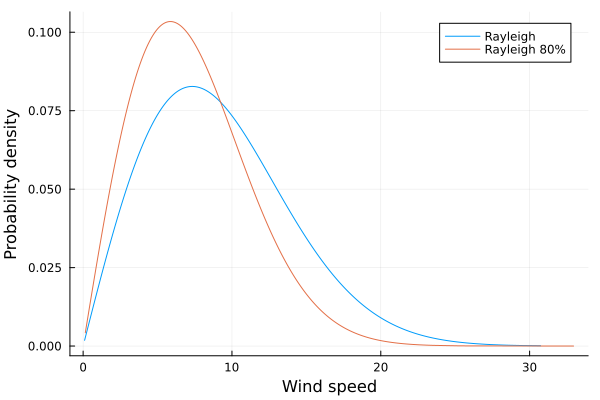

In [9]:
scenarios_orig_sorted = sort(scenarios_orig)
scenarios_sorted = sort(scenarios)
p1 = pdf.(wind_speed_dist_orig, scenarios_orig_sorted)
p2 = pdf.(wind_speed_dist, scenarios_sorted)
p = plot([scenarios_orig_sorted, scenarios_sorted], [p1, p2], 
            label=["Rayleigh" "Rayleigh 80%"], xlabel="Wind speed", ylabel="Probability density", legend=:topright)
savefig(p, "results/rayleigh.png")
p

In [10]:
# generate scenarios and use kmeans to reduce the number of scenarios
n_centers = sum(scenario_map[i]["n_groups"] for i in 1:n_periods)

μ = mean(scenarios)
σ = std(scenarios)

normalized_scenarios = (scenarios .- μ) ./ σ
kmn = Clustering.kmeans(reshape(normalized_scenarios, 1, length(normalized_scenarios)) , n_centers)
wind_speed_values = vec((kmn.centers .* σ) .+ μ)

7-element Vector{Float64}:
 10.955587954462962
  2.0956797273717473
  4.342387226126482
  8.578156463534789
 18.0453904890633
  6.450511759621468
 13.913314280495584

In [11]:
# draw scenario probability from uniform distribution
π_ω = fill(1/n_scenarios, n_scenarios)

4-element Vector{Float64}:
 0.25
 0.25
 0.25
 0.25

In [12]:
cut_in = 3.5 # m/s
cut_out = 25.0 # m/s
rated_wind_speed = 12.0 # m/s
max_power_renewable_generator = 500

function get_power_generation_from_wind(wind_speed, max_power_renewable_generator)
       if wind_speed < cut_in || wind_speed > cut_out
        return 0.0
    end

    if wind_speed < rated_wind_speed
        return max_power_renewable_generator * (wind_speed - cut_in) / (rated_wind_speed - cut_in)
    end

    return max_power_renewable_generator 
end

function form_max_power_gen_per_time_period_and_scenario(max_power_generation)
    P_r_max = Vector{Vector{Float64}}()
    current_power_index = 1
    for t in T
        gen_at_time_t = Vector{Float64}()
        for i in 1:scenario_map[t]["n_groups"]
            group_start = scenario_map[t]["n_scenarios"]*(i-1) + 1
            group_end = scenario_map[t]["n_scenarios"]*i
            for ω in Ω[group_start:group_end]
                push!(gen_at_time_t, max_power_generation[current_power_index])
            end
            current_power_index = current_power_index + 1
        end
        push!(P_r_max, gen_at_time_t)
    end
    return P_r_max
end

form_max_power_gen_per_time_period_and_scenario (generic function with 1 method)

In [13]:
# maximum generation capacity of renewable generators
max_power_generation = [get_power_generation_from_wind(wind_speed_values[i], max_power_renewable_generator) for i in 1:length(wind_speed_values)]
println(max_power_generation)

P_r_max = form_max_power_gen_per_time_period_and_scenario(sort(max_power_generation, rev=true))

for t in T
    println(P_r_max[t])
end

Real[438.56399732135066, 0.0, 49.55218977214603, 298.7150860902817, 500, 173.55951527185104, 500]


[500.0, 500.0, 500.0, 500.0]
[500.0, 500.0, 438.56399732135066, 438.56399732135066]
[298.7150860902817, 173.55951527185104, 49.55218977214603, 0.0]


## Define and solve model

In [14]:
function get_lines_for_node(node, incoming)
    if incoming
        return filter(i -> i >= 1.0, lines[node, 1:end])
    end
    return filter(i -> i <= -1.0, lines[node, 1:end])
end

function get_generator_for_node(node, loc_G)
    return findall(i -> i == node, loc_G)
end

get_generator_for_node (generic function with 1 method)

In [15]:
function define_and_solve_model(P_c_max, P_r_max, B_max, loc_G_c, loc_G_r)
    model = Model(HiGHS.Optimizer)
    set_optimizer_attribute(model, "log_to_console", false)

    @variable(model, P_c_max[g] >= P_c[g in G_c, t in T, ω in Ω] >= 0) 
    @variable(model, P_r_max[t][ω] >= P_r[g in G_r, t in T, ω in Ω] >= 0) 
    @variable(model, F_max[l] >= F[l in L, t in T, ω in Ω] >= -F_max[l])
    @variable(model, D[n] >= D_shed[n in N] >= 0)

    @variable(model, B_max[n] >= B[n in N, t in vcat([0],T), ω in Ω] >= 0) 
    @variable(model, ΔB[n in N, t in T, ω in Ω])

    @constraint(model, init_battery_charge[n in N, ω in Ω], B[n,0,ω] == 0)
    @constraint(model, battery_charge[n in N, t in T, ω in Ω], B[n,t-1,ω] + ΔB[n,t,ω] == B[n,t,ω])

    @constraint(model, power_flow[n in N, t in T, ω in Ω], 
        sum(P_c[g,t,ω] for g in get_generator_for_node(n, loc_G_c))
        + sum(P_r[g,t,ω] for g in get_generator_for_node(n, loc_G_r))
        - D[n]
        + D_shed[n]
        + sum(F[i,t,ω] for i in get_lines_for_node(n, true))
        - sum(F[-i,t,ω] for i in get_lines_for_node(n, false))
        - ΔB[n,t,ω]
        == 0
    )

    for t in T
        for i in 1:scenario_map[t]["n_groups"]
            group_start = scenario_map[t]["n_scenarios"]*(i-1) + 1
            group_end = scenario_map[t]["n_scenarios"]*i
            for ω in Ω[group_start+1:group_end]
                @constraint(model, [g in G_r], P_r[g,t,ω-1]==P_r[g,t,ω])
            end
        end
    end

    @objective(model, Min, sum(π_ω[ω]*c[g]*P_c[g,t,ω] for g in G_c, t in T, ω in Ω) + 100000*sum(D_shed[n] for n in N))

    optimize!(model)

    results = Dict(
        "P_c" => value.(P_c),
        "P_r" => value.(P_r),
        "F" => value.(F),
        "D_shed" => value.(D_shed),
        "B" => value.(B),
        "ΔB" => value.(ΔB),
        "objective" => objective_value(model)
    )
    return results
end

define_and_solve_model (generic function with 1 method)

## Investigate the effect of introduction of battery storage systems

In [16]:
function get_objective_function_value(results)
    return round(Int, results["objective"])
end

function get_number_of_used_batteries(results)
    return sum(Int(any(x -> x > 0, results["ΔB"][n,:,:])) for n in N)
end

get_number_of_used_batteries (generic function with 1 method)

In [17]:
results_initial = define_and_solve_model(P_c_max, P_r_max, B_max, loc_G_c, loc_G_r)

Dict{String, Any} with 7 entries:
  "ΔB"        => 3-dimensional DenseAxisArray{Float64,3,...} with index sets:…
  "B"         => 3-dimensional DenseAxisArray{Float64,3,...} with index sets:…
  "P_r"       => 3-dimensional DenseAxisArray{Float64,3,...} with index sets:…
  "D_shed"    => 1-dimensional DenseAxisArray{Float64,1,...} with index sets:…
  "objective" => 20003.3
  "P_c"       => 3-dimensional DenseAxisArray{Float64,3,...} with index sets:…
  "F"         => 3-dimensional DenseAxisArray{Float64,3,...} with index sets:…

In [18]:
println("Initial network:")
println("Total demand: " * string(sum(D)))
println("Maximum supply of convetional generators: " * string(sum(P_c_max)) * "MW")
println("Maximum supply of renewable generators: " * string(length(G_r)*500) * "MW")

Initial network:
Total demand: 2207
Maximum supply of convetional generators: 2362.5MW
Maximum supply of renewable generators: 2000MW


In [19]:
B_max_non_empty = [100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
results_with_battery_capacity = define_and_solve_model(P_c_max, P_r_max, B_max_non_empty, loc_G_c, loc_G_r)

Dict{String, Any} with 7 entries:
  "ΔB"        => 3-dimensional DenseAxisArray{Float64,3,...} with index sets:…
  "B"         => 3-dimensional DenseAxisArray{Float64,3,...} with index sets:…
  "P_r"       => 3-dimensional DenseAxisArray{Float64,3,...} with index sets:…
  "D_shed"    => 1-dimensional DenseAxisArray{Float64,1,...} with index sets:…
  "objective" => 14313.6
  "P_c"       => 3-dimensional DenseAxisArray{Float64,3,...} with index sets:…
  "F"         => 3-dimensional DenseAxisArray{Float64,3,...} with index sets:…

In [20]:
obj_init = get_objective_function_value(results_initial)
obj_with_batteries = get_objective_function_value(results_with_battery_capacity)
println("Introduction of battery storage systems leads to decrease in production costs from " * string(obj_init) * " to " * string(obj_with_batteries))
println("Or a decrease of " * string(obj_init - obj_with_batteries))

Introduction of battery storage systems leads to decrease in production costs from 20003 to 14314
Or a decrease of 5689


In [21]:
# as wee can see and as was expected, the introduction of battery storage systems leads to a decrease in production costs.
# However, another interesting question would be at what cost this decrease is achieved. To find out we investigate the number of batteries that are used in the second case.

In [22]:
println("Number of used batteries: " * string(get_number_of_used_batteries(results_with_battery_capacity)))

Number of used batteries: 19


In [23]:
# As we can see the number of used batteries is 21 out of a total of 24 batteries.
# Here we suspect that the model chooses randomly which battery to use and therefore not all batteries are utilized completely.
# Next we will investigate wheather we can achieve same decrease in production costs with less batteries.
# First, we try to add batteries at the nodes where wind farms are located.

In [24]:
B_max_selected_1 = [0, 0, 100, 0, 100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 100, 0, 0, 0, 0, 100, 0, 0, 0]
results_with_selected_battery_capacity_1 = define_and_solve_model(P_c_max, P_r_max, B_max_selected_1, loc_G_c, loc_G_r)

Dict{String, Any} with 7 entries:
  "ΔB"        => 3-dimensional DenseAxisArray{Float64,3,...} with index sets:…
  "B"         => 3-dimensional DenseAxisArray{Float64,3,...} with index sets:…
  "P_r"       => 3-dimensional DenseAxisArray{Float64,3,...} with index sets:…
  "D_shed"    => 1-dimensional DenseAxisArray{Float64,1,...} with index sets:…
  "objective" => 16253.4
  "P_c"       => 3-dimensional DenseAxisArray{Float64,3,...} with index sets:…
  "F"         => 3-dimensional DenseAxisArray{Float64,3,...} with index sets:…

In [25]:
obj_init = get_objective_function_value(results_initial)
obj_with_batteries = get_objective_function_value(results_with_battery_capacity)
obj_with_selected_batteries = get_objective_function_value(results_with_selected_battery_capacity_1)
println("Production costs are " * string(obj_init) * ", " * string(obj_with_batteries) * ", " * string(obj_with_selected_batteries))
println("Or a decrease of " * string(obj_init - obj_with_selected_batteries) * " compared to " * string(obj_init - obj_with_batteries))
println("Number of used batteries: " * string(get_number_of_used_batteries(results_with_selected_battery_capacity_1)))

Production costs are 20003, 14314, 16253
Or a decrease of 3750 compared to 5689
Number of used batteries: 4


In [26]:
println(results_with_selected_battery_capacity_1["ΔB"][3,:,:])
println(results_with_selected_battery_capacity_1["ΔB"][5,:,:])
println(results_with_selected_battery_capacity_1["ΔB"][16,:,:])
println(results_with_selected_battery_capacity_1["ΔB"][21,:,:])

2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, [1, 2, 3]
    Dimension 2, [1, 2, 3, 4]
And data, a 3×4 Matrix{Float64}:
 

  -0.0    -0.0    43.30800803594809   100.0
  100.0   100.0    56.69199196405191    -0.0
 -100.0  -100.0  -100.0               -100.0
2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, [1, 2, 3]
    Dimension 2, [1, 2, 3, 4]
And data, a 3×4 Matrix{Float64}:
   73.0    73.0    49.436002678649345    92.7440107145975
   27.0    27.0    50.563997321350655     7.2559892854025065
 -100.0  -100.0  -100.0                -100.0
2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, [1, 2, 3]
    Dimension 2, [1, 2, 3, 4]
And data, a 3×4 Matrix{Float64}:
   -0.0    -0.0   100.0   100.0
  100.0   100.0    -0.0    -0.0
 -100.0  -100.0  -100.0  -100.0
2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, [1, 2, 3]
    Dimension 2, [1, 2, 3, 4]
And data, a 3×4 Matrix{Float64}:
   -0.0    -0.0   100.0    -0.0
  100.0   100.0    -0.0   100.0
 -100.0  -100.0  -100.0  -100.0


In [27]:
# As we can see, each battery was loaded during first and second hour in each scenario to be then used in the third hour.
# The decrease in the production costs is smaller than in the previous case, but the batteries are completely utilized.
# Therefore, we try to increase battery capacity of the 4 batteries.

In [28]:
B_max_selected_2 = [0, 0, 250, 0, 250, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 300, 0, 0, 0, 0, 350, 0, 0, 0]
results_with_selected_battery_capacity_2 = define_and_solve_model(P_c_max, P_r_max, B_max_selected_2, loc_G_c, loc_G_r)

Dict{String, Any} with 7 entries:
  "ΔB"        => 3-dimensional DenseAxisArray{Float64,3,...} with index sets:…
  "B"         => 3-dimensional DenseAxisArray{Float64,3,...} with index sets:…
  "P_r"       => 3-dimensional DenseAxisArray{Float64,3,...} with index sets:…
  "D_shed"    => 1-dimensional DenseAxisArray{Float64,1,...} with index sets:…
  "objective" => 14313.6
  "P_c"       => 3-dimensional DenseAxisArray{Float64,3,...} with index sets:…
  "F"         => 3-dimensional DenseAxisArray{Float64,3,...} with index sets:…

In [29]:
obj_init = get_objective_function_value(results_initial)
obj_with_batteries = get_objective_function_value(results_with_battery_capacity)
obj_with_selected_batteries = get_objective_function_value(results_with_selected_battery_capacity_2)
println("Production costs are " * string(obj_init) * ", " * string(obj_with_batteries) * ", " * string(obj_with_selected_batteries))
println("Or a decrease of " * string(obj_init - obj_with_selected_batteries) * " compared to " * string(obj_init - obj_with_batteries))
println("Number of used batteries: " * string(get_number_of_used_batteries(results_with_selected_battery_capacity_2)))

Production costs are 20003, 14314, 14314
Or a decrease of 5689 compared to 5689
Number of used batteries: 4


In [30]:
println(results_with_selected_battery_capacity_2["ΔB"][3,:,:])
println(results_with_selected_battery_capacity_2["ΔB"][5,:,:])
println(results_with_selected_battery_capacity_2["ΔB"][16,:,:])
println(results_with_selected_battery_capacity_2["ΔB"][21,:,:])

2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, [1, 2, 3]
    Dimension 2, [1, 2, 3, 4]
And data, a 3×4 Matrix{Float64}:
 -0.0   241.0                -0.0               250.0
 -0.0  -236.67854581555315   79.2441817361979   -68.0
 -0.0    -4.32145418444685  -79.2441817361979  -182.0
2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, [1, 2, 3]
    Dimension 2, [1, 2, 3, 4]
And data, a 3×4 Matrix{Float64}:
   99.13965563887314   112.0   112.0                 120.43600267864934
  112.0                112.0    50.563997321350655    50.563997321350655
 -211.13965563887314  -224.0  -162.56399732135066   -171.0
2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, [1, 2, 3]
    Dimension 2, [1, 2, 3, 4]


And data, a 3×4 Matrix{Float64}:
 -0.0    -0.0   300.0    94.80800803594815
 -0.0   300.0    -0.0   205.19199196405185
 -0.0  -300.0  -300.0  -300.0
2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, [1, 2, 3]
    Dimension 2, [1, 2, 3, 4]
And data, a 3×4 Matrix{Float64}:
   -0.0    -0.0                151.0              112.0
  241.0   214.44048472814893   187.447810227854   238.0
 -241.0  -214.44048472814893  -338.447810227854  -350.0


In [31]:
# By gradually increasing the battery capacities, we find those values where in at least one scenario the battery is not fully used.
# Of course the optimal battery size depends on weather severity and on the duration of low wind periods.

## Increase renewable energy generation capacity

In [32]:
function get_number_of_generators_not_used(results)
    return sum(Int(all(x -> x == 0, results["P_c"][g,:,:])) for g in G_c)
end

get_number_of_generators_not_used (generic function with 1 method)

In [33]:
println(get_number_of_generators_not_used(results_initial))
println(get_number_of_generators_not_used(results_with_battery_capacity))
println(get_number_of_generators_not_used(results_with_selected_battery_capacity_1))
println(get_number_of_generators_not_used(results_with_selected_battery_capacity_2))

1
6
2
6


In [34]:
# As we can see even in the case of no batteries, 1 generator was not used at all
# After the introduction of many batteries, there were 6 generators that became obsolete
# ....................

# Next we increase maximum power generation and battery capacities by 200Mw each
# and investigate the number of generators that are not used

In [35]:
# increase maximum generation capacity of renewable generators
max_power_renewable_generator_large = 700
max_power_generation_large = [get_power_generation_from_wind(wind_speed_values[i], max_power_renewable_generator_large) for i in 1:length(wind_speed_values)]
println(max_power_generation_large)

P_r_max_increased_renewables = form_max_power_gen_per_time_period_and_scenario(max_power_generation_large)

for t in T
    println(P_r_max[t])
end

Real[613.989596249891, 0.0, 69.37306568100443, 418.2011205263944, 700, 242.98332138059146, 700]


[500.0, 500.0, 500.0, 500.0]
[500.0, 500.0, 438.56399732135066, 438.56399732135066]
[298.7150860902817, 173.55951527185104, 49.55218977214603, 0.0]


In [36]:
B_max_increased_renewables = [0, 0, 350, 0, 350, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 500, 0, 0, 0, 0, 550, 0, 0, 0]
results_with_increased_renewables = define_and_solve_model(P_c_max, P_r_max_increased_renewables, B_max_increased_renewables, loc_G_c, loc_G_r)

Dict{String, Any} with 7 entries:
  "ΔB"        => 3-dimensional DenseAxisArray{Float64,3,...} with index sets:…
  "B"         => 3-dimensional DenseAxisArray{Float64,3,...} with index sets:…
  "P_r"       => 3-dimensional DenseAxisArray{Float64,3,...} with index sets:…
  "D_shed"    => 1-dimensional DenseAxisArray{Float64,1,...} with index sets:…
  "objective" => 15473.0
  "P_c"       => 3-dimensional DenseAxisArray{Float64,3,...} with index sets:…
  "F"         => 3-dimensional DenseAxisArray{Float64,3,...} with index sets:…

In [37]:
println(get_number_of_generators_not_used(results_with_increased_renewables))

6


In [38]:
println(results_with_increased_renewables["P_r"])

3-dimensional DenseAxisArray{Float64,3,...} with index sets:
    Dimension 1, [1, 2, 3, 4]
    Dimension 2, [1, 2, 3]
    Dimension 3, [1, 2, 3, 4]
And data, a 4×3×4 Array{Float64, 3}:
[:, :, 1] =
 613.989596249891  0.0  418.2011205263944
 613.989596249891  0.0  418.2011205263944
 613.989596249891  0.0  418.2011205263944
 613.989596249891  0.0  418.2011205263944

[:, :, 2] =
 613.989596249891  0.0  449.0
 613.989596249891  0.0  700.0
 613.989596249891  0.0  700.0
 613.989596249891  0.0  358.0

[:, :, 3] =
 613.989596249891  69.37306568100443  242.98332138059146
 613.989596249891  69.37306568100443  242.98332138059146
 613.989596249891  69.37306568100443  242.98332138059146
 613.989596249891  69.37306568100443  242.98332138059146

[:, :, 4] =
 613.989596249891  69.37306568100443  700.0
 613.989596249891  69.37306568100443  678.0
 613.989596249891  69.37306568100443  700.0
 613.989596249891  69.37306568100443  129.0


In [39]:
println(results_with_increased_renewables["ΔB"][3,:,:])
println(results_with_increased_renewables["ΔB"][5,:,:])
println(results_with_increased_renewables["ΔB"][16,:,:])
println(results_with_increased_renewables["ΔB"][21,:,:])

2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, [1, 2, 3]
    Dimension 2, [1, 2, 3, 4]
And data, a 3×4 Matrix{Float64}:
  34.01040375010905   350.0   19.626934318995566   350.0
 -34.01040375010905  -350.0  -19.626934318995566  -350.0
  -0.0                 -0.0   -0.0                  -0.0
2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, [1, 2, 3]
    Dimension 2, [1, 2, 3, 4]
And data, a 3×4 Matrix{Float64}:
  225.98959624989095   225.98959624989095   225.98959624989095   318.62693431899555
 -225.98959624989095  -225.98959624989095  -225.98959624989095  -318.62693431899555
   -0.0                 -0.0                 -0.0                 -0.0
2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, [1, 2, 3]
    Dimension 2, [1, 2, 3, 4]
And data, a 3×4 Matrix{Float64}:
  370.9583849995638   216.9791924997819   500.0                 216.9791924997819
 -370.9583849995638  -216.9791924997819  -468.933285522

## Substitute convetional generators with renewable generators

In [40]:
# function get_lines_that_reached_capacity(results)
#     return findall(x -> x == F_max, results["F"])
# end
# get_lines_that_reached_capacity(results_initial)
# get_lines_that_reached_capacity(results_with_battery_capacity)

In [41]:
# # cost of generation for convetional generators
# c = [20.93, 26.11, 10.52, 10.52, 6.02, 5.47, 7, 10.52, 10.89]

# # Location of the generators
# loc_G_c = [13, 15, 15, 16, 18, 21, 22, 23, 23]
# loc_G_r = [1, 2, 7, 3, 5, 16, 21]

# # maximum generation capacity of convetional generators
# P_c_max = [413.7, 42, 108.5, 108.5, 280, 280, 210, 217, 245] 

# # maximum generation capacity of renewable generators
# P_r_max = []

In [42]:
# function save_to_file(data, filename)
#     open(filename, "w") do io
#         JSON.print(io, data, 4)
#     end
# end
# save_to_file(results_initial, "results/initial.json")